In [98]:
from IPython.display import IFrame
import folium
import json
import pandas as pd
import scipy as sp
import math
import seaborn as sns
import matplotlib.pyplot as plt
from branca.colormap import LinearColormap, StepColormap, linear
import numpy as np

In [8]:
FIPS_codes = pd.read_csv('../Data_clean/fipscountries.csv', usecols = ['country', 'fips'])\
    .rename(index=str, columns={'fips':'FIPS'})\
    .rename(index=str, columns={'country':'Country'})
FIPS_codes.head()

,FIPS,Country
0,AN,Andorra
1,AE,United Arab Emirates
2,AF,Afghanistan
3,AC,Antigua and Barbuda
4,AV,Anguilla


### TOOLS FOR MAPS

In [68]:
world_borders = json.load(open('../Data_clean/world_borders.topojson.json'))

In [69]:
def color_function(feature, data, color_fun):
    value = data.get(feature['properties']['name'])
    if value is None:
        return '#8c8c8c' # MISSING -> gray
    else:
        return color_fun(value)

### BOOTSTRAPPING

In [94]:

def bootstrapping(data, number_of_sample, features, t=1.96):
    feature1 = features[0]
    feature2 = features[1]
    r = []
    sample_size = len(data)
    for i in range(number_of_sample):
        rnd_idx = np.random.randint(0, len(data), size=sample_size)
        data_sampled = data.iloc[rnd_idx]
        pearson_coeff = sp.stats.pearsonr(data_sampled[feature1], data_sampled[feature2])[0]
        # if the sample contains only identical values, the std is zero and pearsonr return NaN because of 
        # an impossible division by zero
        if not math.isnan(pearson_coeff):
            r.append(pearson_coeff)
     
    r_mean = np.mean(r) 
    z = np.log((1+r_mean)/(1-r_mean))/2
    std_err = 1/np.sqrt(sample_size-3)
    lower_z = z - std_err*t
    upper_z = z + std_err*t
    
    lower_r = (np.exp(2*lower_z)-1)/(np.exp(2*lower_z)+1)
    upper_r = (np.exp(2*upper_z)-1)/(np.exp(2*upper_z)+1)
    CI = (lower_r, upper_r)
    return r , CI

### Link between media content and happiness of the inhabitants

#### 1. Does global tone related to a country's events reflects its happiness level ?


The following query was submitted to Google BigQuery, in order to get the average `MentionDocTone` over all events happening in each country :
<br> <br>


*SELECT ActionGeo_CountryCode as FIPS, AVG(MentionDocTone) as Average_tone*

*FROM `gdelt-bq.gdeltv2.eventmentions` as a*

*INNER JOIN (SELECT ActionGeo_CountryCode, GLOBALEVENTID FROM `gdelt-bq.gdeltv2.events`) as b*

*ON a.GLOBALEVENTID = b.GLOBALEVENTID*

*WHERE MentionType=1*

*GROUP BY ActionGeo_CountryCode*
<br><br>

Then we load the resulting table :

In [9]:
averageTone_locEvent = pd.read_csv('../Data_clean/AverageTone_LocEvent.csv')
averageTone_locEvent.head()

,FIPS,Average_tone
0,TU,-3.275389
1,SC,0.995833
2,PK,-3.806824
3,QA,-1.615441
4,CR,-1.917010


We load the table containing the Happiness Score per country, obtained from the World Happiness Report (2018).

In [21]:
happinessData = pd.read_excel('../Data_clean/HappinessData.xls', sheet_name = 'Figure2.2', usecols="A,B")\
    # merging with FIPS_codes in order to make the link with country names
    .merge(FIPS_codes, left_on='Country', right_on='Country')
happinessData.head()

,Country,Happiness score,FIPS
0,Finland,7.6321,FI
1,Norway,7.5937,NO
2,Denmark,7.5553,DA
3,Iceland,7.4952,IC
4,Switzerland,7.4873,SZ


In [22]:
# Merging the table containing the average tone and the table containing the happiness score
happiness_tone_locEvent = averageTone_locEvent.merge(happinessData, left_on='FIPS', right_on='FIPS')
happiness_tone_locEvent.head()

,FIPS,Average_tone,Country,Happiness score
0,TU,-3.275389,Turkey,5.4825
1,PK,-3.806824,Pakistan,5.4725
2,QA,-1.615441,Qatar,6.3745
3,MK,-1.253623,Macedonia,5.1848
4,LE,-3.058331,Lebanon,5.1989


Now, let's plot the data and compute the correlation between these two variables :

Text(0.5, 0, 'Happiness score of the country')

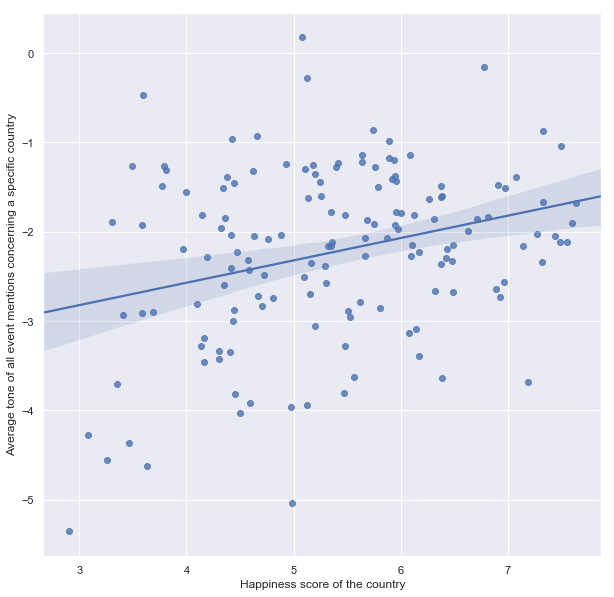

In [33]:
# we use seaborn regplot function to have both the scatter plot and a regression line on top
sns.set(rc={'figure.figsize':(10,10)})
sns.regplot('Happiness score', 'Average_tone', data=happiness_tone_locEvent)
plt.ylabel("Average tone of all event mentions concerning a specific country")
plt.xlabel("Happiness score of the country")

In [28]:
print('The Pearson correlation between Average Tone of event mentions concerning a specific country and the Happiness Score of this country is : ')
pearson_coef = happiness_tone_locEvent['Happiness score'].corr(happiness_tone_locEvent['Average_tone'])
print(pearson_coef)

The Pearson correlation between Average Tone of event mentions concerning a specific country and the Happiness Score of this country is : 
0.2928961717911641


We also apply bootstrapping on the Pearson Correlation statistic in order to be more confident with the result :

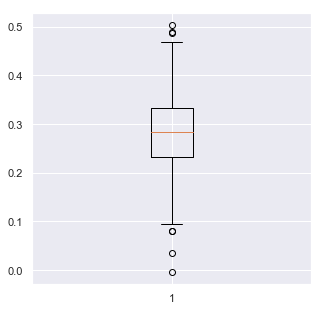

In [132]:
number_of_samples = 200

pearson_coefs, pearson_coef_ci = bootstrapping(happiness_tone_locEvent, \
                                                                   number_of_samples, \
                                                                   features=['Happiness score', \
                                                                             'Average_tone'] \
                                                               )

plt.boxplot(pearson_coefs, \
              conf_intervals=[pearson_coef_ci], \
               manage_xticks = True \
             )




sns.set(rc={'figure.figsize':(5,5)})


#### 2. Is there a link between media tone from a country sources and Happiness level ?
The following query was submitted to Google BigQuery, in order to get the average `MentionDocTone` over all sources of each country :
<br> <br>

*SELECT FIPS, AVG(MentionDocTone) as AverageTone*

*FROM `gdelt-bq.gdeltv2.eventmentions`*

*INNER JOIN `gdelt-bq.extra.sourcesbycountry`*

*ON MentionSourceName=Domain*

*GROUP BY FIPS*
<br><br>

Then we load the resulting table :

In [19]:
averageTone_locSource = pd.read_csv('../Data_clean/avgToneBySourceLocation_table.csv')
averageTone_locSource.head()

,FIPS,AverageTone
0,IT,-1.226632
1,WA,-2.156439
2,CM,-2.944971
3,ML,-1.462604
4,MG,-0.242109


In [23]:
# Merging the table containing the average tone and the table containing the happiness score
happiness_locSource = averageTone_locSource.merge(happinessData, left_on='FIPS', right_on='FIPS')
happiness_locSource.head()

,FIPS,AverageTone,Country,Happiness score
0,IT,-1.226632,Italy,6.0004
1,WA,-2.156439,Namibia,4.4413
2,CM,-2.944971,Cameroon,4.9753
3,ML,-1.462604,Mali,4.4470
4,MG,-0.242109,Mongolia,5.1246


Now we plot the data and compute the correlation between both variables.

Text(0.5, 0, 'Happiness score of the country')

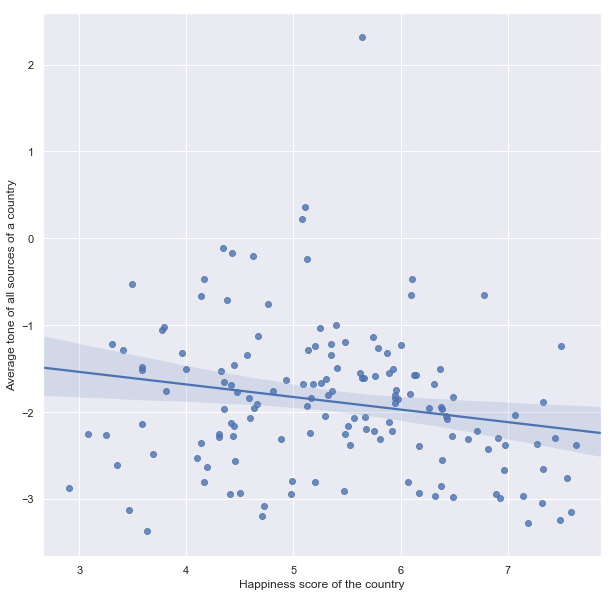

In [133]:
# we use seaborn regplot function to have both the scatter plot and a regression line on top
sns.set(rc={'figure.figsize':(10,10)})
sns.regplot('Happiness score', 'AverageTone', data=happiness_locSource)
plt.ylabel("Average tone of all sources of a country")
plt.xlabel("Happiness score of the country")

In [29]:
print('The Pearson correlation between Average Tone of all sources of a country and the Happiness Score of this country is : ')
pearson_coef = happiness_locSource['Happiness score'].corr(happiness_locSource['AverageTone'])
print(pearson_coef)

The Pearson correlation between Average Tone of all sources of a country and the Happiness Score of this country is : 
-0.19582880426865243


We also apply bootstrapping on the Pearson Correlation statistic in order to be more confident with the result :

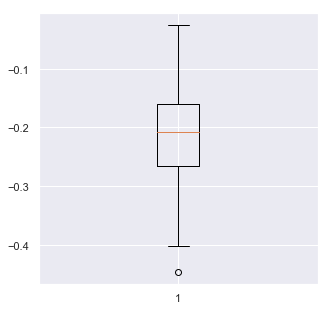

In [135]:
number_of_samples = 200

pearson_coefs, pearson_coef_ci = bootstrapping(happiness_locSource, \
                                                                   number_of_samples, \
                                                                   features=['Happiness score', \
                                                                             'AverageTone'] \
                                                               )

plt.boxplot(pearson_coefs, \
              conf_intervals=[pearson_coef_ci], \
               manage_xticks = True \
             )

sns.set(rc={'figure.figsize':(5,5)})
plt.rcParams["figure.figsize"] = fig_size

#### 3. Is there a link between the average Goldstein Scale value of all events happening in a country and its happiness score ?

The following query was submitted to Google BigQuery, in order to get the average `GoldsteinScale` over all events happening in each country :
<br><br>

*SELECT ActionGeo_CountryCode as FIPS, AVG(GoldsteinScale) AS GoldsteinScale*

*FROM `gdelt-bq.gdeltv2.events`*

*GROUP BY ActionGeo_CountryCode*

<br><br> Then we load the resulting table :

In [30]:
GoldsteinScale = pd.read_csv('../Data_clean/GoldsteinScale_fullRange.csv')
GoldsteinScale.head()

,FIPS,GoldsteinScale
0,CQ,1.515194
1,ER,0.883016
2,QA,1.566748
3,RP,0.311488
4,PF,-0.943179


In [31]:
# Merging with the table containing the happiness score
happiness_GoldsteinScale = GoldsteinScale.merge(happinessData, left_on='FIPS', right_on='FIPS')
happiness_GoldsteinScale.head()

,FIPS,GoldsteinScale,Country,Happiness score
0,QA,1.566748,Qatar,6.3745
1,RP,0.311488,Philippines,5.5241
2,AO,1.535179,Angola,3.7948
3,PM,1.005327,Panama,6.4300
4,PE,1.046938,Peru,5.6632


We plot on a World map, the average Goldstein Scale per country, in order to visualize the geographical repartition of this value.

In order to match Goldstein Scale values per country, to the delimited countries in the topojson file, we need to change the name of some countries, e.g. replace 'United States' by 'United States of America'.

In [71]:
# Changing some country names for more correspondance
happiness_GoldsteinScale.loc[happiness_GoldsteinScale['Country']=='United States', 'Country'] = 'United States of America'
happiness_GoldsteinScale.loc[happiness_GoldsteinScale['Country']=='Serbia', 'Country'] = 'Republic of Serbia'

print(happiness_GoldsteinScale['GoldsteinScale'].describe())

# Converting GoldsteinScale values into a dictionnary (necessary to create the map)
GoldsteinScale_dict = happiness_GoldsteinScale.set_index('Country')['GoldsteinScale'].to_dict()


count    148.000000
mean       0.797604
std        0.563220
min       -1.274651
25%        0.531858
50%        0.913096
75%        1.173711
max        1.839942
Name: GoldsteinScale, dtype: float64


In [73]:
Goldstein_map = folium.Map(tiles='Mapbox bright', zoom_start=5.5)

# Defining a style function to color the map and the borders
style_func=lambda feature: {'fillColor': '#990033','color' : 'black','weight' : 2 }

# Using a GeoJsonTooltip to display country name when mouse is over them
tool=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'], sticky=True, \
                           style="font-family: Arial; color: black;", \
                           opacity=0.8, \
                           direction='top' \
                          )

# Load border information on the map
folium.TopoJson(world_borders,\
                object_path='objects.countries1',\
                style_function=style_func,\
                tooltip=tool, \
                overlay=False \
               ) \
      .add_to(Goldstein_map)

color_scale_Goldstein = LinearColormap(['red','blue'], \
                                     vmin = min(GoldsteinScale_dict.values()), \
                                     vmax = max(GoldsteinScale_dict.values()) \
                                    )

# Adding Goldstein Scale values on the map
folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, GoldsteinScale_dict, color_scale_Goldstein),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Average Goldstein Scale',
    ).add_to(Goldstein_map)

color_scale_Goldstein.caption = 'Average Goldstein Scale per country (full date range)'
Goldstein_map.add_child(color_scale_Goldstein)
folium.LayerControl().add_to(Goldstein_map)
Goldstein_map

We plot the data repartition between Goldstein Scale and happiness score variables.
    Then we compute the correlation and use some bootstrapping in order to be more confident with the result: 

Text(0.5, 0, 'Happiness score of the country')

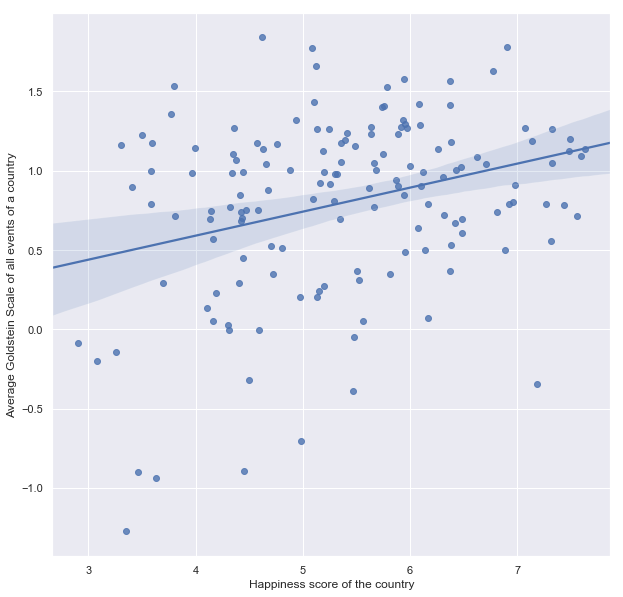

In [140]:
# we use seaborn regplot function to have both the scatter plot and a regression line on top
sns.set(rc={'figure.figsize':(10,10)})
sns.regplot('Happiness score', 'GoldsteinScale', data=happiness_GoldsteinScale)
plt.ylabel("Average Goldstein Scale of all events of a country")
plt.xlabel("Happiness score of the country")

In [141]:
print('The Pearson correlation between Average Goldstein Scale of all events of a country and the Happiness Score of this country is : ')
pearson_coef = happiness_GoldsteinScale['Happiness score'].corr(happiness_GoldsteinScale['GoldsteinScale'])
print(pearson_coef)

The Pearson correlation between Average Goldstein Scale of all events of a country and the Happiness Score of this country is : 
0.3045946758739501


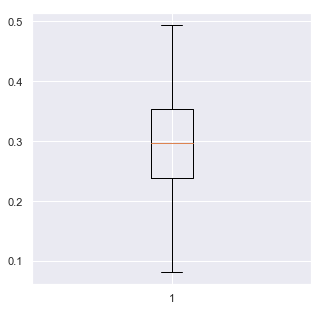

In [136]:
# Bootstrapping to get a more confident correlation statistics
number_of_samples = 200

pearson_coefs, pearson_coef_ci = bootstrapping(happiness_GoldsteinScale, \
                                                                   number_of_samples, \
                                                                   features=['Happiness score', \
                                                                             'GoldsteinScale'] \
                                                               )

plt.boxplot(pearson_coefs, \
              conf_intervals=[pearson_coef_ci], \
               manage_xticks = True \
             )

sns.set(rc={'figure.figsize':(5,5)})
plt.rcParams["figure.figsize"] = fig_size

### Link between media content and political background of a country

#### 1. Correlation between Democratic quality and average tone

First, we are interested in the link between the Democratic Quality score of a country, and the average tone of its media sources.
Concerning the average tone, we use the table `averageTone_locSource` created previously.
The Democratic Quality score is obtained from Wikipedia's Democracy Index dataset. These data collected from the Economist also classify the Democratic Quality score into 4 different categories, as follows :

## ADD DATA FROM SINAN's PART

In [142]:
DemocraticQualityData = pd.read_csv('../Data_clean/democracy_index.csv', usecols=['Country', 'Score', 'Category'])\
    .rename(index=str, columns={'Score':'Democratic Quality'})\
    # Merging with the FIPS codes because it is originally based on country names
    .merge(FIPS_codes, left_on='Country', right_on='Country')

DemocraticQualityData.head()

,Country,Democratic Quality,Category,FIPS
0,Norway,9.87,Full democracy,NO
1,Iceland,9.58,Full democracy,IC
2,Sweden,9.39,Full democracy,SW
3,New Zealand,9.26,Full democracy,NZ
4,Denmark,9.22,Full democracy,DA


In [42]:
# Merging with the Average Tone data
DemocraticQuality_AvgTone_locSource = DemocraticQualityData.merge(averageTone_locSource, left_on='FIPS', right_on='FIPS')
DemocraticQuality_AvgTone_locSource.head()

,Country,Democratic Quality,Category,FIPS,AverageTone
0,Norway,9.87,Full democracy,NO,-3.147385
1,Iceland,9.58,Full democracy,IC,-1.240504
2,Sweden,9.39,Full democracy,SW,-3.043232
3,New Zealand,9.26,Full democracy,NZ,-1.889038
4,Denmark,9.22,Full democracy,DA,-2.763428


Text(0.5, 0, 'Democratic Quality score of the country')

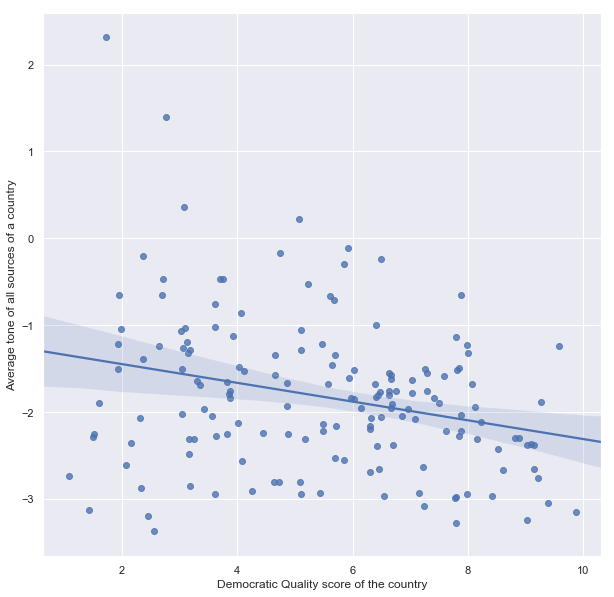

In [43]:
# we use seaborn regplot function to have both the scatter plot and a regression line on top
sns.set(rc={'figure.figsize':(10,10)})
sns.regplot('Democratic Quality', 'AverageTone', data=DemocraticQuality_AvgTone_locSource)
plt.ylabel("Average tone of all sources of a country")
plt.xlabel("Democratic Quality score of the country")

In [44]:
print('The Pearson correlation between Democratic Quality and Average Tone is : ')
print(DemocraticQuality_AvgTone_locSource['Democratic Quality'].corr(DemocraticQuality_AvgTone_locSource['AverageTone']))


The Pearson correlation between Democratic Quality and Average Tone is : 
-0.2699187830251109


We also apply bootstrapping on the Pearson Correlation statistic in order to be more confident with the result :

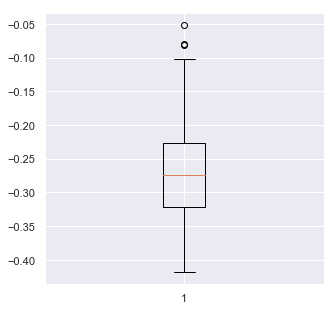

In [137]:
number_of_samples = 200

pearson_coefs, pearson_coef_ci = bootstrapping(DemocraticQuality_AvgTone_locSource, \
                                                                   number_of_samples, \
                                                                   features=['Democratic Quality', \
                                                                             'AverageTone'] \
                                                               )

plt.boxplot(pearson_coefs, \
              conf_intervals=[pearson_coef_ci], \
               manage_xticks = True \
             )

sns.set(rc={'figure.figsize':(5,5)})
plt.rcParams["figure.figsize"] = fig_size

Now, dividing the countries depending on their Democratic category, we plot the average tone per category :

In [143]:
categories = ['Authoritarian', 'Hybrid regime', 'Flawed democracy', 'Full democracy']
mapping = {cat: i for i, cat in enumerate(categories)}
key = DemocraticQuality_AvgTone_locSource['Category'].map(mapping)

DemocraticQuality_AvgTone_locSource.iloc[key.argsort()]


DemocraticQuality_AvgTone_categories=DemocraticQuality_AvgTone_locSource.groupby('Category')['AverageTone']\
    .apply(np.mean)
DemocraticQuality_AvgTone_categories.head()

Category
Authoritarian      -1.557733
Flawed democracy   -1.969316
Full democracy     -2.357073
Hybrid regime      -1.693918
Name: AverageTone, dtype: float64

Text(0, 0.5, 'Average Tone')

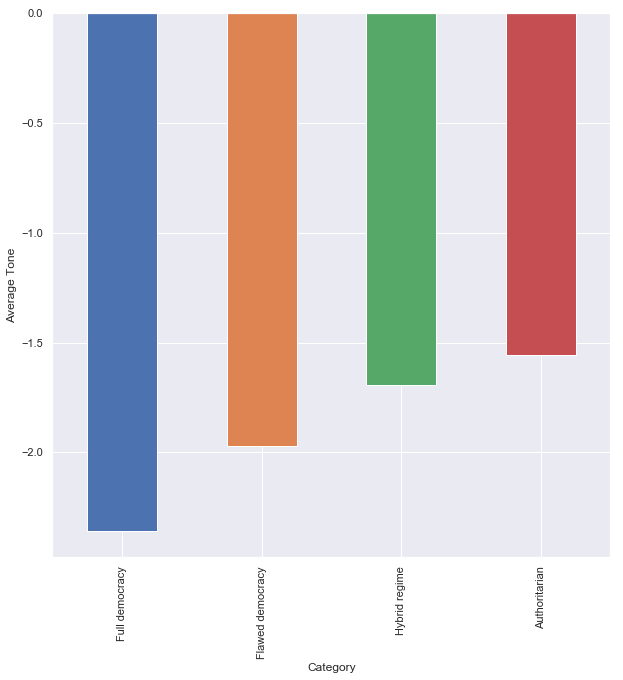

In [145]:
DemocraticQuality_AvgTone_categories.sort_values().plot.bar()
plt.ylabel('Average Tone')

We select some event categories that we find relevant : 'Fight', 'Exhibit Force Posture', 'Protest', 'Engage in diplomatic cooperation' and 'Engage in material cooperation'.

And we compute the average tone for each country sources, for each of these event types (using the `EventRootCode` parameter) :
<br><br>

*SELECT FIPS, EventRootCode, AVG(MentionDocTone) as AverageTone*

*FROM `iron-stack-223417.ProjetGDELT.eventmentions_sources_table` a*

*INNER JOIN (SELECT GLOBALEVENTID, EventRootCode*

*FROM `gdelt-bq.gdeltv2.events`*

*WHERE EventRootCode IN ('19', '15', '14', '05', '06')) b*

*ON a.GLOBALEVENTID=b.GLOBALEVENTID*

*GROUP BY FIPS, EventRootCode*
<br><br>

Then we load the resulting table :

In [61]:
averageTone_locSource_EventRootCode = pd.read_csv('../Data_clean/avgToneBySourceLocation_EventRootCode.csv')
averageTone_locSource_EventRootCode.head()

,FIPS,EventRootCode,AverageTone
0,SZ,19,-5.297849
1,RQ,5,-0.182663
2,KN,19,-4.212330
3,LH,5,0.477984
4,TD,15,-2.464236


In [146]:
# Merging with the democratic categories data : 
averageTone_democraticQuality_EventRootCode = DemocraticQualityData\
    .merge(averageTone_locSource_EventRootCode, left_on='FIPS', right_on='FIPS')
averageTone_democraticQuality_EventRootCode.head()

,Country,Democratic Quality,Category,FIPS,EventRootCode,AverageTone
0,Norway,9.87,Full democracy,NO,6,-1.867430
1,Norway,9.87,Full democracy,NO,14,-4.604183
2,Norway,9.87,Full democracy,NO,15,-3.198755
3,Norway,9.87,Full democracy,NO,19,-5.768208
4,Norway,9.87,Full democracy,NO,5,-1.115457


Then we plot the average for each of these Event categories, depending on the Democratic Category:

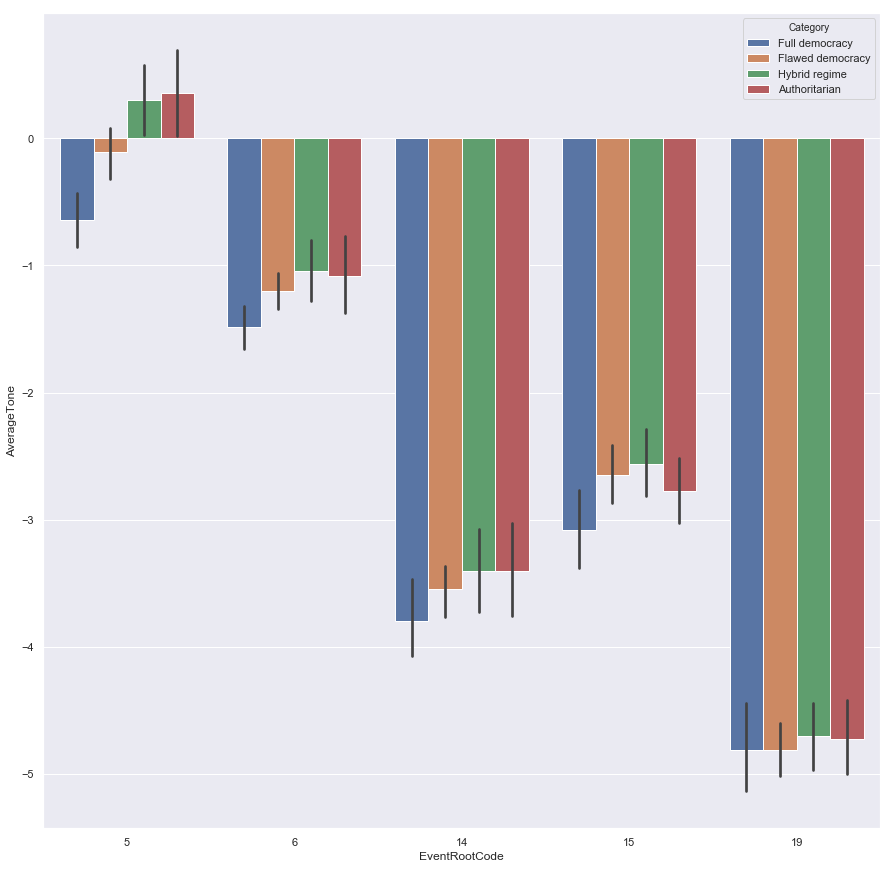

In [63]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size
sns.barplot(x="EventRootCode", y="AverageTone", hue="Category", data=averageTone_democraticQuality_EventRootCode)

#### 2. Difference in average tone between internal and external sources

Let's look at the difference in the way media sources talk about their origin country, as compared to how foreign media talk about it.
Then, let's see if there is a correlation between this difference of vision and the democratic quality of the country.

We submitted a query on Google BigQuery in order to have the average `MentionDocTone` for all internal sources of a country, concerning events happening in this country :
<br><br>

*SELECT ActionGeo_CountryCode as EventLocation, AVG(MentionDocTone) as AvgTone_Intern*

*FROM (SELECT MentionDocTone, FIPS, ActionGeo_CountryCode*
*FROM `iron-stack-223417.ProjetGDELT.eventmentions_sources_table` as a*
*JOIN `gdelt-bq.gdeltv2.events` as b* <br>
*ON a.GLOBALEVENTID=b.GLOBALEVENTID)*

*WHERE FIPS= ActionGeo_CountryCode*
*GROUP BY ActionGeo_CountryCode*

In [75]:
avgTone_internalSources = pd.read_csv('../Data_clean/avgTone_internalSources.csv')
avgTone_internalSources = avgTone_internalSources.merge(FIPS_codes, left_on='EventLocation', right_on='FIPS')\
    .drop('FIPS', axis=1)
avgTone_internalSources.head()

,EventLocation,AvgTone_Intern,Country
0,ZA,-0.822406,Zambia
1,LO,-1.806090,Slovakia
2,AL,-1.590928,Albania
3,CW,0.579648,Cook Islands
4,RO,-1.307122,Romania


We will plot the average tone of all internal sources on a map.

In order to match Average tone values per country, to the delimited countries in the topojson file, we need to change the name of some countries, e.g. replace 'United States' by 'United States of America'.

In [76]:
avgTone_internalSources.loc[avgTone_internalSources['Country']=='United States', 'Country'] = 'United States of America'
avgTone_internalSources.loc[avgTone_internalSources['Country']=='Serbia', 'Country'] = 'Republic of Serbia'
print(avgTone_internalSources['AvgTone_Intern'].describe())

avgTone_internalSources_dict = avgTone_internalSources.set_index('Country')['AvgTone_Intern'].to_dict()


count    212.000000
mean      -0.937858
std        1.345638
min       -3.845790
25%       -1.795483
50%       -1.091014
75%       -0.432748
max        3.351737
Name: AvgTone_Intern, dtype: float64


Then we submitted a query on Google BigQuery in order to have the average `MentionDocTone` for all sources external to a country, concerning events happening in this country :
<br><br>

*SELECT ActionGeo_CountryCode as EventLocation, AVG(MentionDocTone) as AvgTone_Intern*

*FROM (SELECT MentionDocTone, FIPS, ActionGeo_CountryCode*
*FROM `iron-stack-223417.ProjetGDELT.eventmentions_sources_table` as a*
*JOIN `gdelt-bq.gdeltv2.events` as b* <br>
*ON a.GLOBALEVENTID=b.GLOBALEVENTID)*

*WHERE FIPS!= ActionGeo_CountryCode*
*GROUP BY ActionGeo_CountryCode*

In [79]:
avgTone_externalSources = pd.read_csv('../Data_clean/avgTone_externalSources.csv')
avgTone_externalSources = avgTone_externalSources.merge(FIPS_codes, left_on='EventLocation', right_on='FIPS')\
    .drop('FIPS', axis=1)
avgTone_externalSources.head()

,EventLocation,AvgTone_Extern,Country
0,NT,-0.675984,Netherlands Antilles
1,AU,-2.316602,Austria
2,MA,-1.708456,Madagascar
3,ZA,-1.990604,Zambia
4,VM,-1.913008,Vietnam


In [80]:
avgTone_externalSources.loc[avgTone_externalSources['Country']=='United States', 'Country'] = 'United States of America'
avgTone_externalSources.loc[avgTone_externalSources['Country']=='Serbia', 'Country'] = 'Republic of Serbia'
print(avgTone_externalSources['AvgTone_Extern'].describe())
avgTone_externalSources_dict = avgTone_externalSources.set_index('Country')['AvgTone_Extern'].to_dict()


count    235.000000
mean      -2.312214
std        1.143217
min       -5.595630
25%       -2.981656
50%       -2.220734
75%       -1.543780
max        0.730550
Name: AvgTone_Extern, dtype: float64


In [81]:
world_map = folium.Map(tiles='Mapbox bright', zoom_start=5.5)

# Defining a style function to color the map and the borders
style_func=lambda feature: {'fillColor': '#990033','color' : 'black','weight' : 2 }

# Using a GeoJsonTooltip to display country name when mouse is over them
tool=folium.GeoJsonTooltip(fields=['name'], aliases=['Country:'], sticky=True, \
                           style="font-family: Arial; color: black;", \
                           opacity=0.8, \
                           direction='top' \
                          )

# Load border information on the map
folium.TopoJson(world_borders,\
                object_path='objects.countries1',\
                style_function=style_func,\
                tooltip=tool, \
                overlay=False \
               ) \
      .add_to(world_map)

color_scale = LinearColormap(['red','blue'], \
                #vmin = min(avgTone_internalSources_dict.values()), \
                #vmax = max(avgTone_internalSources_dict.values()) \
                              vmin=-5.6, vmax= 3.4)

# FIRST MAP
folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, avgTone_internalSources_dict, color_scale),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Average tone in internal medias'
    ).add_to(world_map)

# SECOND MAP
folium.TopoJson(
    world_borders,
    object_path='objects.countries1',
    style_function=lambda feature: {
        'fillColor': color_function(feature, avgTone_externalSources_dict, color_scale),
        'color' : 'black',
        'weight' : 1,
        'dashArray' : '5, 5',
        'fillOpacity' : 0.8
        },
    tooltip=folium.GeoJsonTooltip(fields=['name'],aliases=['Country: '], sticky=True, style="font-family: Arial; color: black;", \
                           opacity=0.8, direction='top'),
    name = 'Average tone in external medias',
    show=False
    ).add_to(world_map)

color_scale.caption = 'Average tone concerning all country events'
world_map.add_child(color_scale)
folium.LayerControl().add_to(world_map)
world_map  

In [87]:
# We merge internal sources and external sources dataframes
avgTone_Difference = avgTone_externalSources\
    .merge(avgTone_internalSources, right_on=['Country','EventLocation'], left_on=['Country','EventLocation'])
avgTone_Difference.head()

,EventLocation,AvgTone_Extern,Country,AvgTone_Intern
0,AU,-2.316602,Austria,-1.471840
1,MA,-1.708456,Madagascar,-0.679975
2,ZA,-1.990604,Zambia,-0.822406
3,VM,-1.913008,Vietnam,1.141849
4,GR,-2.664889,Greece,-1.243538


In [88]:
# Now we compute the tone difference 
avgTone_Difference['Tone Difference'] = avgTone_Difference['AvgTone_Intern']\
    .subtract(avgTone_Difference['AvgTone_Extern'])\

print(avgTone_Difference['Tone Difference'].describe())
avgTone_Difference.head()  

count    212.000000
mean       1.431066
std        1.333073
min       -2.186083
25%        0.512585
50%        1.208890
75%        2.059483
max        8.071409
Name: Tone Difference, dtype: float64


,EventLocation,AvgTone_Extern,Country,AvgTone_Intern,Tone Difference
0,AU,-2.316602,Austria,-1.471840,0.844762
1,MA,-1.708456,Madagascar,-0.679975,1.028481
2,ZA,-1.990604,Zambia,-0.822406,1.168197
3,VM,-1.913008,Vietnam,1.141849,3.054858
4,GR,-2.664889,Greece,-1.243538,1.421351


In [91]:
# We merge it with the democratic quality data, in order to see if there is a correlation
avgTone_Difference_DemocraticQuality = DemocraticQualityData.merge(avgTone_Difference, left_on=['FIPS','Country'], right_on=["EventLocation",'Country'])
avgTone_Difference_DemocraticQuality = avgTone_Difference_DemocraticQuality[['Country','Democratic Quality','Tone Difference']]
avgTone_Difference_DemocraticQuality.head()

,Country,Democratic Quality,Tone Difference
0,Norway,9.87,0.065328
1,Iceland,9.58,0.474964
2,Sweden,9.39,0.334264
3,New Zealand,9.26,0.727949
4,Denmark,9.22,0.311634


Text(0.5, 0, 'Democratic Quality score of the country')

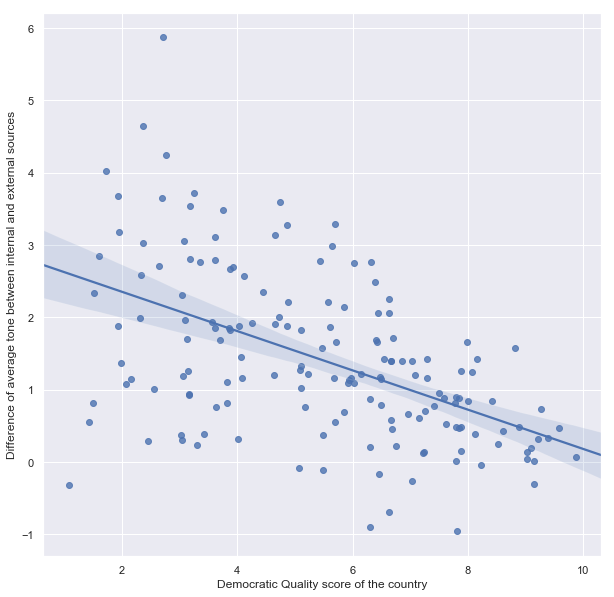

In [148]:
# we use seaborn regplot function to have both the scatter plot and a regression line on top
sns.set(rc={'figure.figsize':(10,10)})
sns.regplot('Democratic Quality', 'Tone Difference', data=avgTone_Difference_DemocraticQuality)
plt.ylabel("Difference of average tone between internal and external sources")
plt.xlabel("Democratic Quality score of the country")

In [93]:
print('The Pearson correlation between Democratic Quality and Average Tone difference is : ')
print(avgTone_Difference_DemocraticQuality['Democratic Quality']\
      .corr(avgTone_Difference_DemocraticQuality['Tone Difference']))

The Pearson correlation between Democratic Quality and Average Tone relative difference is : 
-0.5148148458864259


We also apply bootstrapping on the Pearson Correlation statistic in order to be more confident with the result :

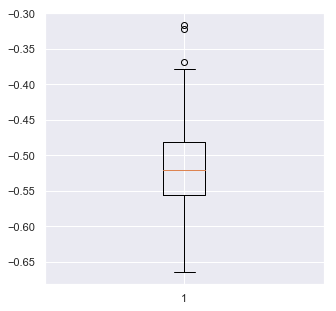

In [138]:
number_of_samples = 200

pearson_coefs, pearson_coef_ci = bootstrapping(avgTone_Difference_DemocraticQuality, \
                                                                   number_of_samples, \
                                                                   features=['Democratic Quality', \
                                                                             'Tone Difference'] \
                                                               )

plt.boxplot(pearson_coefs, \
              conf_intervals=[pearson_coef_ci], \
               manage_xticks = True \
             )

sns.set(rc={'figure.figsize':(5,5)})
plt.rcParams["figure.figsize"] = fig_size